In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras import backend as K

from tqdm.autonotebook import tqdm

tqdm.pandas()

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

from PIL import Image
import keras.backend as K
# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

BASE_DATA_DIR = Path('/media/disk1/anerinovsky/data/nplt')
# BASE_DATA_DIR.mkdir()

import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

BASE_MODEL_DIR = Path('/media/disk1/anerinovsky/models/')

import json
from pathlib import Path
import functools as ft


Using TensorFlow backend.
/nfs/home/anerinovsky/miniconda3/envs/c3d/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/nfs/home/anerinovsky/miniconda3/envs/c3d/lib/python3.7/site-packages/tqdm/_tqdm.py:634: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Extract layers from tensorflow model 

In [ ]:

# K.res

import keras
from keras.layers import Input
from argparse import Namespace 
from keras.models import Model, load_model

num_classes = 10

CIFAR10_LABELS_LIST = [
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

K.set_learning_phase(0)

(x_train, y_train), (x_test_raw, y_test_raw) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test_raw, num_classes)

x_train, x_test = ResNet.color_preprocessing(None, x_train, x_test_raw)

img_input = Input(shape=(32, 32, 3))


_self = Namespace(weight_decay=0.0001)
output, activations = ResNet.residual_network(_self, img_input, num_classes, stack_n=5, need_activations=True)
model = Model(img_input, activations)
model.load_weights('networks/models/resnet.h5')

In [ ]:
import keras.backend as K

from lucid.misc.io.showing import graph, _strip_consts

graph(K.get_session().graph.as_graph_def())

In [ ]:
from collections import defaultdict

class Node(object):

  def __init__(self, name, op, shape, raw_node, pretty_name=None):
    self.name = name
    self.op = op
    self.pretty_name = pretty_name
    self.shape = shape
    self.raw_node = raw_node

  def __repr__(self):
    return "<%s: %s (%s)>" % (self.name, self.op, self.shape)

  @property
  def inputs(self):
    return self.graph.node_to_inputs[self.name]

  @property
  def consumers(self):
    return self.graph.node_to_consumers[self.name]


class TfGraph(object):

  def __init__(self):
    self.nodes = []
    self.name_map = {}
    self.node_to_consumers = defaultdict(lambda: [])
    self.node_to_inputs = defaultdict(lambda: [])

  def add_node(self, node):
    self.nodes.append(node)
    self.name_map[node.name] = node

  def add_edge(self, node1, node2):
    node1, node2 = self[node1], self[node2]
    self.node_to_consumers[node1.name].append(node2)
    self.node_to_inputs[node2.name].append(node1)

  def __getitem__(self, index):
    if isinstance(index, str):
      return self.name_map[index]
    elif isinstance(index, Node):
      return self.name_map[index.name]
    else:
      raise Exception("Unsupported index for Graph", type(index) )

  @staticmethod
  def from_graphdef(graphdef):

    graph = Graph()

    for raw_node in graphdef.node:
        shape =  [ d.size for d in raw_node.attr['shape'].shape.dim ]
        graph.add_node(Node(raw_node.name, raw_node.op, shape, raw_node))

    for raw_node in graphdef.node:
      for raw_inp in raw_node.input:
        if raw_inp.startswith('^'):  # skip control inputs
          continue
        raw_inp_name = raw_inp.split(":")[0]
        graph.add_edge(raw_inp_name, raw_node.name)

    return graph


    

In [ ]:
gd = K.get_session().graph.as_graph_def()

In [ ]:
g = TfGraph.from_graphdef(gd)

class VisGraph:
    def __init__(self):
        self.node_packs = {}
        self.node_packs_links = {}

    def add_node_pack(self, name, shape):
        
        assert name not in self.node_packs
        
        self.node_packs[name] = shape
        
        
    def link_node_packs_elwise(self, pn1, pn2):
        pass
    
class ElwiseLink:
    def __init__(self):
        pass
    def render(self, adj, )
    


class SubGraph:

    def __init__(self, name=None):
        self.name = name
        self.nodes = [] # defaultdict(list)
        # self.inputs = []
        self.consumers = []
    
    def __repr__(self):
        return f"SubGraph(name={self.name})"
    
    


d = defaultdict(SubGraph)
for node in g.nodes:
    name = node.name.split('/')[0]
    d[name].name = name
    d[name].nodes.append(node)
    
    for cons in g.node_to_consumers[node.name]:
        cons_name = cons.name.split('/')[0]
        if cons_name != name:
            d[name].consumers.append(d[cons_name])
            


# Build adajency matrices for convolutions

In [ ]:
### from keras.utils.conv_utils import conv_output_length
from scipy.sparse import csr_matrix

def conv_output_length(input_length, filter_size, padding, stride, dilation=1):

    if input_length is None:
        return None
    
    assert padding in {'same', 'valid', 'full', 'causal'}
    
    dilated_filter_size = (filter_size - 1) * dilation + 1
    
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

def calculate_padding(input_length, filter_size, padding, stride, dilation=1):
    
    assert padding in {'same', 'valid', 'full', 'causal'}
    
    if padding == 'same':
        return ((stride-1)*input_length-stride+filter_size)//2
    elif padding == 'valid':
        return 0
    
    
def conv2d_adj(input, kernel, bias, strides, padding, dilation):
    '''
    input : [1,H,W,C]
    kernel: [filter_height, filter_width, in_channels, out_channels]
    '''
    batch_size, ih, iw, ic = input.shape
    kh, kw, kic, koc = kernel.shape
    
    # assert kh % 2 == 1 and kw % 2 == 1, f'Expecting odd sized kernels, but got: {kernel.size}'
    
    _, oh, ow, oc = output_shape = [batch_size, 
                    conv_output_length(ih, kh, padding=padding, 
                                       stride=strides[0], dilation=dilation[0]),
                    conv_output_length(iw, kw, padding=padding,
                                       stride=strides[1], dilation=dilation[1]),
                    koc
    ]
    
    ph, pw = [calculate_padding(ih, kh, padding=padding, 
                                       stride=strides[0], dilation=dilation[0]),
              calculate_padding(iw, kw, padding=padding, 
                                       stride=strides[1], dilation=dilation[1]) 
    ]
    
    padded_input = np.pad(input, ((0,0), (ph, ph), (pw, pw), (0,0)), mode='constant')
    # padded_input_shape = [batch_size, ih+ph*2, iw+pw*2, ic]
    
    print('padding', ph, pw)
    print('output_shape', output_shape)
    print('input_shape', input.shape)
    print('padded_input_shape', padded_input.shape)
    
    
    i_nodes = np.arange(np.prod(padded_input.shape)).reshape(padded_input.shape)
    
    o_nodes = i_nodes.size + np.arange(np.prod(output_shape)).reshape(output_shape)
    
    num_nodes = i_nodes.size + o_nodes.size
        
    adj_mx = csr_matrix((num_nodes, num_nodes))
    
    for b in range(batch_size):
        for i in range(ow):
            for j in range(oh):
                for ko in range(koc):
                    _i_nodes = i_nodes[b, i:i+kw, j:j+kh, :].ravel()
                    assert len(_i_nodes) == kernel[..., ko].size 
                    
                    adj_mx[o_nodes[b, i, j],  _i_nodes] = 1 # (kernel[..., ko] * padded_input[b, i:i+kw, j:j+kh, :]).ravel()
                    # adj_mx[_i_nodes, o_nodes[b, i, j]] = 1
    return adj_mx

adj_mx = conv2d_adj(np.zeros([1,9, 9,1]), np.ones((3, 3, 1, 1)), [1, 1], 'same', [1, 1])
plt.imshow(adj_mx.todense())

In [ ]:
import networkx as nx

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=10)
    plt.show()


show_graph_with_labels(adj_mx.todense())



In [ ]:
def maxpool_adj(input, kernel_size, strides, padding):
    '''
    input : [1,H,W,C]
    kernel: [filter_height, filter_width, in_channels, out_channels]
    '''
    batch_size, ih, iw, ic = input.shape
    kh, kw = kernel_size
    
    # assert kh % 2 == 1 and kw % 2 == 1, f'Expecting odd sized kernels, but got: {kernel_size}'
    
    _, oh, ow, oc = output_shape = [batch_size, 
                    conv_output_length(ih, kh, padding=padding, 
                                       stride=strides[0]),
                    conv_output_length(iw, kw, padding=padding,
                                       stride=strides[1]),
                    ic
    ]
    
    ph, pw = [calculate_padding(ih, kh, padding=padding, 
                                       stride=strides[0]),
              calculate_padding(iw, kw, padding=padding, 
                                       stride=strides[1]) 
    ]
    
    padded_input = np.pad(input, ((0,0), (ph, ph), (pw, pw), (0,0)), mode='constant')
    # padded_input_shape = [batch_size, ih+ph*2, iw+pw*2, ic]
    
    print('padding', ph, pw)
    print('output_shape', output_shape)
    print('input_shape', input.shape)
    print('padded_input_shape', padded_input.shape)
    
    
    i_nodes = np.arange(np.prod(padded_input.shape)).reshape(padded_input.shape)
    
    o_nodes = i_nodes.size + np.arange(np.prod(output_shape)).reshape(output_shape)
    
    num_nodes = i_nodes.size + o_nodes.size
        
    adj_mx = csr_matrix((num_nodes, num_nodes))
    
    for b in range(batch_size):
        for i in range(ow):
            for j in range(oh):
                _i_nodes = i_nodes[b, i:i+kw, j:j+kh, :].ravel()
                # assert len(_i_nodes) == kernel[..., ko].size 

                _input = padded_input[b, i:i+kw, j:j+kh, :].ravel()
                _edges = np.zeros_like(_input)
                m_ix = _input.argmax()
                _edges[m_ix] = _input[m_ix]
                adj_mx[o_nodes[b, i, j],  _i_nodes] = 1 #_edges
                
    return adj_mx

adj_mx = maxpool_adj(np.random.randn(1,8, 8,1), [2,2], [2, 2], 'valid')
plt.imshow(adj_mx.todense())

In [ ]:
show_graph_with_labels(adj_mx.todense())

In [ ]:
def elwise_adj(input, op=None):
    '''
    input : [1,H,W,C]
    kernel: [filter_height, filter_width, in_channels, out_channels]
    '''
    batch_size, ih, iw, ic = input.shape
    output_shape = input.shape
    
    i_nodes = np.arange(np.prod(input.shape)).reshape(input.shape)
    
    o_nodes = i_nodes.size + np.arange(np.prod(output_shape)).reshape(output_shape)
    
    num_nodes = i_nodes.size + o_nodes.size
        
    adj_mx = csr_matrix((num_nodes, num_nodes))
    
    
    for b in range(batch_size):
        _i_nodes = i_nodes[b, ...].ravel()
        _o_nodes = o_nodes[b, ...].ravel()
        adj_mx[_o_nodes,  _i_nodes] = 1 #_edges
                
    return adj_mx

adj_mx = elwise_adj(np.random.randn(1,8, 8,1))
plt.imshow(adj_mx.todense())

In [ ]:
show_graph_with_labels(adj_mx.todense())

In [ ]:
def dense_adj(input, weigth, output):
    '''
    input : [1,H,W,C]
    kernel: [filter_height, filter_width, in_channels, out_channels]
    '''
    batch_size, ih, iw, ic = input.shape
    output_shape = input.shape
    
    i_nodes = np.arange(np.prod(input.shape)).reshape(input.shape)
    
    o_nodes = i_nodes.size + np.arange(np.prod(output_shape)).reshape(output_shape)
    
    num_nodes = i_nodes.size + o_nodes.size
        
    adj_mx = csr_matrix((num_nodes, num_nodes))
    
    
    for b in range(batch_size):
        _i_nodes = i_nodes[b, ...].ravel()
        _o_nodes = o_nodes[b, ...].ravel()
        adj_mx[_o_nodes,  _i_nodes] = 1 #_edges
                
    return adj_mx

# Try to plot lenet

In [1]:
from keras.models import  load_model

import keras
import numpy as np
from keras import optimizers
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.layers import Conv2D, Dense, Input, add, Activation, GlobalAveragePooling2D
from keras.models import Model, load_model
import keras.backend as K

input_shape = 32, 32, 3

x = img_input = Input(shape=(32, 32, 3))
weight_decay = 0.0001

acts = []
x = Conv2D(6, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay), input_shape=input_shape)(x)
acts.append(x) 
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
acts.append(x) 
x = Conv2D(16, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)
acts.append(x) 
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
acts.append(x) 
x = Flatten()(x)
acts.append(x) 
x = Dense(120, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay) )(x)
acts.append(x) 
x = Dense(84, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay) )(x)
acts.append(x) 
x = Dense(10, activation = 'softmax', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay) )(x)
acts.append(x) 

model = Model(img_input, acts)


input_name = 'input_1'

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mean = [125.307, 122.95, 113.865]
std  = [62.9932, 62.0887, 66.7048]
for i in range(3):
    x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
    x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    
model.load_weights('networks/models/lenet.h5')
model.summary()



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_____________________________________________________

In [ ]:

t = sess.graph.get_tensor_by_name('conv2d_1/BiasAdd:0') # .eval(session=sess, )
t.eval(feed_dict = {
    sess.graph.get_tensor_by_name('input_1:0') : x_train[:1]
}, session=sess)

In [ ]:
o = sess.graph.get_operation_by_name('conv2d_1/BiasAdd')
o.run(feed_dict = {
    sess.graph.get_tensor_by_name('input_1:0') : x_train[:1]
}, session=sess)

In [ ]:
input = x_test[:1]
acts = OrderedDict(zip((l.name for l in model.layers[1:]), model.predict(input)))
weights = OrderedDict(zip((w.name for w in model.weights), model.get_weights()))

## Plotting

In [147]:
from layout import plot_graph3d, layout_tensors

## Battle advanced indexing

In [ ]:
a = np.arange(64).reshape(8, 8)
a[[0, 1], [0, 1]] = 100
a

## Reshape

In [ ]:

y = x = np.random.randn(1,8, 8,4)

adj_mx, w_mx = elwise_adj(x, y)

node_w = np.concatenate([x.ravel(), y.ravel()])

for i, node_x in enumerate(node_w):
    w_mx[i, i] = node_x
    # BUG: for some reason we need this for correct edge coloring
    adj_mx[i,i] = node_x

layout = layout_as_tensors3d([x.shape[1:], y.reshape(1, -1).shape[1:]])


plot_graph3d(layout, adj_mx, w_mx)

## Dense

In [ ]:

x = np.random.randn(1,10)*0
x[:, 5] = 1000
w = np.random.randn(10, 20)

y = x@w

def dense_adj(input, output, weight, bias=None):
    batch_size, h_dim = input.shape
    batch_size, o_dim = output.shape
    
    assert weight.shape == (h_dim, o_dim)
    
    i_nodes = np.arange(np.prod(input.shape)).reshape(input.shape)
    
    o_nodes = i_nodes.size + np.arange(np.prod(output.shape)).reshape(output.shape)
    
    num_nodes = i_nodes.size + o_nodes.size
        
    adj_mx = lil_matrix((num_nodes, num_nodes))
    w_mx = lil_matrix((num_nodes, num_nodes))
    
    
    _i_nodes = i_nodes.ravel()
    _o_nodes = o_nodes.ravel()
    for b in range(batch_size):
        
        for i, _o_node in enumerate(o_nodes[b, ...]):
            adj_mx[_o_node,  _i_nodes] = 1 #_edges
            w_mx[_o_node,  _i_nodes] = weight[:, i]*input[b]
                
    return adj_mx, w_mx


adj_mx, w_mx = dense_adj(x, y, w)

node_w = np.concatenate([x.ravel(), y.ravel()])

for i, node_x in enumerate(node_w):
    w_mx[i, i] = node_x
    # BUG: for some reason we need this for correct edge coloring
    adj_mx[i,i] = node_x

layout = layout_as_tensors3d([x.shape[1:], y.reshape(1, -1).shape[1:]])


plot_graph3d(layout, adj_mx, w_mx)

## Relu

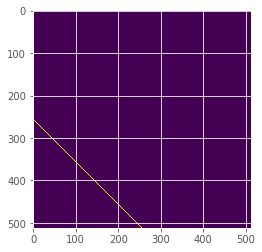

In [145]:
from scipy.sparse import lil_matrix

def elwise_adj(input, output, op=None):
    '''
    input : [1,H,W,C]
    kernel: [filter_height, filter_width, in_channels, out_channels]
    '''
    batch_size, ih, iw, ic = input.shape
    output_shape = input.shape
    
    i_nodes = np.arange(np.prod(input.shape)).reshape(input.shape)
    
    o_nodes = i_nodes.size + np.arange(np.prod(output_shape)).reshape(output_shape)
    
    num_nodes = i_nodes.size + o_nodes.size
        
    adj_mx = lil_matrix((num_nodes, num_nodes))
    w_mx = lil_matrix((num_nodes, num_nodes))
    
    
    #for b in range(batch_size):
    _i_nodes = i_nodes.ravel()
    _o_nodes = o_nodes.ravel()
    adj_mx[_o_nodes,  _i_nodes] = 1 #_edges
    w_mx[_o_nodes,  _i_nodes] = output.ravel()
                
    return adj_mx, w_mx

x = np.random.randn(1,8, 8,4)
y = np.sin(x)
adj_mx, w_mx = elwise_adj(x, y)
plt.imshow(adj_mx.todense())

In [160]:
node_w = np.concatenate([x.ravel(), y.ravel()])

for i, node_x in enumerate(node_w):
    w_mx[i, i] = node_x
    # BUG: for some reason we need this for correct edge coloring
    adj_mx[i,i] = node_x

layout = layout_tensors([x, y])

from layout import _layout, _edges_trace, _nodes_trace, iplot
import plotly.graph_objs as go

fig = go.Figure(data=[
    _nodes_trace(layout, w_mx.toarray()),
])
iplot(fig)

# plot_graph3d(layout, adj_mx.toarray(), w_mx.toarray())

## Convolutions

In [ ]:
from scipy.sparse import lil_matrix


def calculate_padding(input_length, filter_size, padding, stride, dilation=1):
    
    assert padding in {'same', 'valid', 'full', 'causal'}
    
    if padding == 'same':
        return int(np.ceil(((stride-1)*input_length-stride+filter_size)/2))
    elif padding == 'valid':
        return 0
    

def pad_for_conv2d(input, kernel_shape, padding, strides, dilation):
    
    batch_size, ih, iw, ic = input.shape
    kh, kw, kic, koc = kernel_shape
    
    
    ph, pw = [calculate_padding(ih, kh, padding=padding, 
                                       stride=strides[0], dilation=dilation[0]),
              calculate_padding(iw, kw, padding=padding, 
                                       stride=strides[1], dilation=dilation[1]) 
    ]
    
    return np.pad(input, ((0,0), (ph, ph), (pw, pw), (0,0)), mode='constant')

def conv2d_adj(input, output, kernel, bias, strides, dilation):
    '''
        input : [1,H,W,C]
        kernel: [filter_height, filter_width, 
                    in_channels, out_channels]
    '''
    batch_size, ih, iw, ic = input.shape
    kh, kw, kic, koc = kernel.shape
    
    _, oh, ow, oc = output.shape
    
    print('output_shape', output.shape)
    print('padded_input_shape', input.shape)
    
    
    i_nodes = np.arange(np.prod(input.shape)).reshape(input.shape)
    
    o_nodes = i_nodes.size + np.arange(np.prod(output.shape)).reshape(output.shape)
    
    num_nodes = i_nodes.size + o_nodes.size
        
    adj_mx = lil_matrix((num_nodes, num_nodes))
    w_mx = lil_matrix((num_nodes, num_nodes))
    
    for b in range(batch_size):
        for i in range(ow):
            for j in range(oh):
                for ko in range(koc):
                    print(i,j)
                    _i, _j = i*strides[0], j*strides[1]
                    _i_nodes = i_nodes[b, _i:_i+kw, _j:_j+kh, :]
                    
                    assert _i_nodes.size == kernel[..., ko].size, f"{_i_nodes.size} {kernel[..., ko].size}"
                    
                    w = (kernel[..., ko] * padded_input[b, _i:_i+kw, _j:_j+kh, :]).ravel() 
                    if bias is not None:
                        w += bias[ko]
                    # print(o_nodes[b, i, j],  i_nodes[b, i:i+kw, j:j+kh, :], w.shape)
                    
                    adj_mx[o_nodes[b, i, j, ko],  _i_nodes.ravel()] = 1 
                    w_mx[o_nodes[b, i, j, ko],  _i_nodes.ravel()] = w
    return adj_mx, w_mx, (0, i_nodes.size), (i_nodes.size + 1, i_nodes.size  + o_nodes.size)

In [ ]:

x = np.random.randn(1, 4, 4, 1)
k = np.random.randn(3, 3, 1, 1)
y = K.conv2d(tf.convert_to_tensor(x, dtype=tf.float32), kernel=tf.convert_to_tensor(k, dtype=tf.float32),
             strides=(1, 1), padding='same').eval(session=K.get_session())

_x = pad_for_conv2d(x, padding='same',  strides=(1, 1), dilation=(1,1), kernel_shape=k.shape)
print(_x.shape, x.shape)
adj_mx, w_mx, i_range, o_range = conv2d_adj(_x, y, kernel=k, strides=(1, 1), bias=None, dilation=(1,1))


In [ ]:
node_w = np.concatenate([_x.ravel(), y.ravel()])

for i, node_x in enumerate(node_w):
    w_mx[i, i] = node_x
    # BUG: for some reason we need this for correct edge coloring
    adj_mx[i,i] = node_x

layout = layout_as_tensors3d([_x.shape[1:], y.shape[1:]])


plot_graph3d(layout, adj_mx, w_mx)

In [ ]:
name = list(acts)[0]
adj_mx, w_mx, i_range, o_range = conv2d_adj(input, acts[name], 
           weights[f'{name}/kernel:0'], weights[f'{name}/bias:0'], strides=(1,1), padding='valid', dilation=(1,1))

## Max pooling

In [ ]:
def maxpool_adj(input, output, kernel_size, strides, padding):
    '''
    input : [1,H,W,C]
    kernel: [filter_height, filter_width, in_channels, out_channels]
    '''
    batch_size, ih, iw, ic = input.shape
    kh, kw = kernel_size
    
    # assert kh % 2 == 1 and kw % 2 == 1, f'Expecting odd sized kernels, but got: {kernel_size}'
    
    _, oh, ow, oc = output.shape
    
    ph, pw = [calculate_padding(ih, kh, padding=padding, 
                                       stride=strides[0]),
              calculate_padding(iw, kw, padding=padding, 
                                       stride=strides[1]) 
    ]
    
    padded_input = np.pad(input, ((0,0), (ph, ph), (pw, pw), (0,0)), mode='constant')
    # padded_input_shape = [batch_size, ih+ph*2, iw+pw*2, ic]
    
    print('padding', ph, pw)
    # print('output_shape', output_shape)
    print('input_shape', input.shape)
    print('padded_input_shape', padded_input.shape)
    
    
    i_nodes = np.arange(np.prod(padded_input.shape)).reshape(padded_input.shape)
    
    o_nodes = i_nodes.size + np.arange(np.prod(output.shape)).reshape(output.shape)
    
    num_nodes = i_nodes.size + o_nodes.size
        
    adj_mx = csr_matrix((num_nodes, num_nodes))
    w_mx = csr_matrix((num_nodes, num_nodes))
    
    for b in range(batch_size):
        for i in range(ow):
            for j in range(oh):
                _i, _j = i*strides[0], j*strides[1]
                _i_nodes = i_nodes[b, _i:_i+kw, _j:_j+kh, :].ravel()
                # assert len(_i_nodes) == kernel[..., ko].size 

                _input = padded_input[b, _i:_i+kw, _j:_j+kh, :].ravel()
                _edges = np.zeros_like(_input)
                m_ix = _input.argmax()
                
                
                # print(o_nodes[b, i, j, :].shape,  _i_nodes.shape, _edges.shape)
                
                ixs = np.ix_(o_nodes[b, i, j, :],  _i_nodes)
                
                # assert adj_mx[ixs].size == o_nodes[b, i, j, :].size +  _i_nodes.size
                _edges[m_ix] = 1
                adj_mx[ixs] = _edges 
                _edges[m_ix] = _input[m_ix]
                w_mx[ixs] = _edges
                
    return adj_mx, w_mx, (0, i_nodes.size), (i_nodes.size + 1, i_nodes.size  + o_nodes.size)

In [ ]:
x = np.random.randn(1, 4, 4, 1)
y = K.pool2d(tf.convert_to_tensor(x, dtype=tf.float32), 
             pool_size=(2, 2), strides=(2, 2)).eval(session=K.get_session())

adj_mx, w_mx, i_range, o_range = maxpool_adj(x, y, kernel_size=(2,2), strides=(2, 2), padding='valid')

In [ ]:
node_w = np.concatenate([x.ravel(), y.ravel()])

for i, node_x in enumerate(node_w):
    w_mx[i, i] = node_x
    # BUG: for some reason we need this for correct edge coloring
    adj_mx[i,i] = node_x

layout = layout_as_tensors3d([x.shape[1:], y.shape[1:]])


plot_graph3d(layout, adj_mx, w_mx)

# Build an interface

In [37]:
from networks.lenet import LeNet
from keras.datasets import cifar10


lenet = LeNet(input_shape=(32, 32, 3))
input_name = lenet._model.input.name.split(':')[0]


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mean = [125.307, 122.95, 113.865]
std  = [62.9932, 62.0887, 66.7048]
for i in range(3):
    x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
    x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]

Successfully loaded lenet


In [7]:
from lucid.misc.io.showing import graph

sess = K.get_session()
graph(sess.graph)

In [43]:
from netgraph import NetGraph, Tensor, register_op
from nets import lenet

ng = lenet()


Successfully loaded lenet
Converting tf_ops to tensors



Converting tf_vars to weights


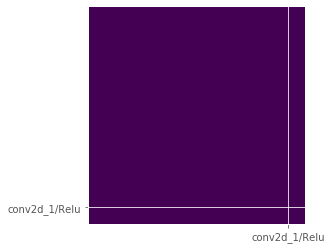

In [167]:
ng.plot_mxs(['conv2d_1/Relu', 'max_pooling2d_2/MaxPool'], ng.adj_mx)

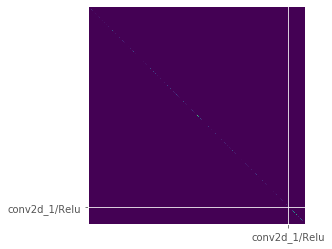

In [168]:
ng.plot_mxs(['conv2d_1/Relu', 'max_pooling2d_2/MaxPool'], ng.w_mx)

### Test graph plotting

In [4]:
import igraph

ig = ng.igraph()


In [5]:
ig.summary()

'IGRAPH U-W- 18084 660214 -- \n+ attr: tensor (v), weight (v), weight (e)'

In [106]:
# layout = ig.layout("grid")
# layout = ig.layout_lgl(maxiter=100)
layout = ig.layout_fruchterman_reingold(weights='weight', maxiter=40)

array([[-635572.72413487, -851294.71568214],
       [-431988.06841828, -966621.44094482],
       [ 709775.78287989, -769033.46734632],
       ...,
       [-110349.61736776, -156855.51803136],
       [   8519.22649374,   -9615.40998457],
       [   5681.72927592,    2553.95272457]])

In [86]:
cmap = plt.get_cmap('seismic')

vertex_color = [(int(r*255), int(g*255), int(b*255)) for r, g, b, a in map(cmap, ig.vs["weight"])]


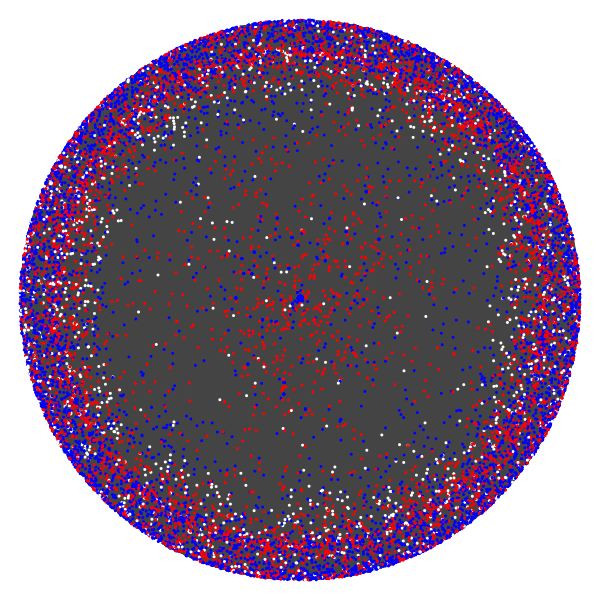

In [107]:
plot = igraph.plot(ig, layout = layout, vertex_size=3, edge_size=0.5, vertex_color=vertex_color, vertex_frame_width=0)
plot.save('graph.png')
Image.open('graph.png')

In [ ]:
layout = ig.layout_fruchterman_reingold(weights='weight', maxiter=150)

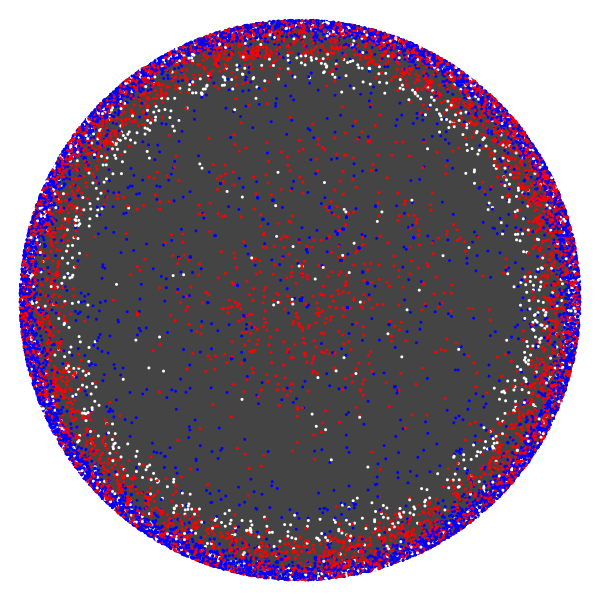

In [109]:
plot = igraph.plot(ig, layout = layout, vertex_size=3, edge_size=0.01, vertex_color=vertex_color, vertex_frame_width=0)
plot.save('graph.png')
Image.open('graph.png')

### Create a colormap

In [64]:
import itertools as it

values = np.array(list(it.chain.from_iterable(t.data.ravel() for t in tqdm(ng.tensors.values()))))

In [65]:
values.mean(), values.std()

(0.15071976, 2.8258162)

(array([1.0000e+00, 5.0000e+00, 2.0000e+00, 9.0000e+00, 2.8000e+01,
        1.2200e+02, 5.7400e+02, 1.5689e+04, 1.5710e+03, 8.3000e+01]),
 array([-50.839363 , -44.130783 , -37.422207 , -30.713629 , -24.00505  ,
        -17.296473 , -10.587894 ,  -3.8793163,   2.8292618,   9.53784  ,
         16.246418 ], dtype=float32),
 <a list of 10 Patch objects>)

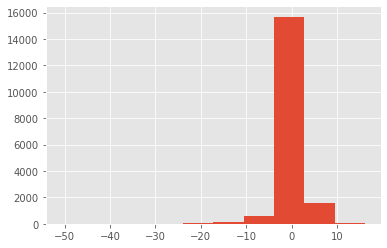

In [68]:
plt.hist(values)

(array([  84.,  150.,  294.,  764., 4265., 9897., 1467.,  560.,  248.,
         102.]),
 array([-9.971404  , -7.980549  , -5.9896936 , -3.9988384 , -2.0079832 ,
        -0.01712799,  1.9737272 ,  3.9645824 ,  5.9554377 ,  7.946293  ,
         9.937148  ], dtype=float32),
 <a list of 10 Patch objects>)

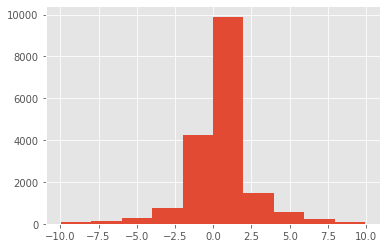

In [69]:
plt.hist(values[np.abs(values) < 10 ])

(array([ 162.,  260.,  507., 1447., 7310., 3476., 1948.,  908.,  549.,
         362.]),
 array([-4.9977736e+00, -3.9981818e+00, -2.9985898e+00, -1.9989979e+00,
        -9.9940598e-01,  1.8596649e-04,  9.9977791e-01,  1.9993699e+00,
         2.9989617e+00,  3.9985538e+00,  4.9981456e+00], dtype=float32),
 <a list of 10 Patch objects>)

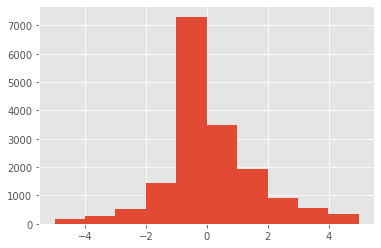

In [70]:
plt.hist(values[np.abs(values) < 5])

In [197]:
i = IterWithLen(ng.edges(), ng.num_edges())  

len(i)

660214

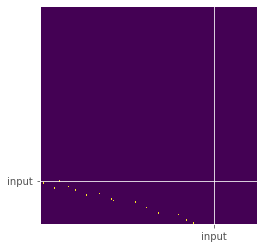

In [163]:
from netgraph import NetGraph, Tensor, register_op
import tensorflow as tf

inp = np.random.randn(1, 10, 10, 3)
outp = K.pool2d(tf.convert_to_tensor(inp, dtype=tf.float32), 
             pool_size=(2, 2), strides=(2, 2)).eval(session=K.get_session())

ng = NetGraph()

tensors = { 'input' : inp, 'maxpool_res' : outp }
for name, t in tensors.items():
    ng.register_tensor(t, name=name)


ng.build_matrix()

x = ng.maxpool2d(('input', 'maxpool_res'), pool_size=(2,2), strides=(2,2))
ng.plot_mxs(['input', 'maxpool_res'], ng.adj_mx)

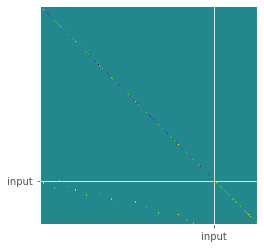

In [164]:
ng.plot_mxs(['input', 'maxpool_res'], ng.w_mx)

In [144]:
ng.plot_3d(['input', 'maxpool_res'])

layout [[-4 -4  0]
 [-4 -4  1]
 [-4 -4  2]
 ...
 [ 2  2  4]
 [ 2  2  5]
 [ 2  2  6]] (375, 3)
75 edges in graph


In [ ]:
ng.edges()

In [189]:
mx = lil_matrix((10, 10))
mx[1, 2] = 100
mx[1, 3] = 101

mx.rows, mx.data

(array([list([]), list([2, 3]), list([]), list([]), list([]), list([]),
        list([]), list([]), list([]), list([])], dtype=object),
 array([list([]), list([100.0, 101.0]), list([]), list([]), list([]),
        list([]), list([]), list([]), list([]), list([])], dtype=object))

In [109]:
from scipy.sparse import coo_matrix, lil_matrix, bmat

bmx = bmat([ [mx[1:4, 1:4], None], [None, mx[8:, 8:]] ], 'lil')

bmx[0, 2] = 4
# mx[8:, 8:].ndim, mx[1:4, 1:4].ndim
mx.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [ ]:
mx = adj_mx.todense().astype(int)

header = f'''DL N={mx.size}\nData:\n'''

import io
bio = io.BytesIO()
np.savetxt(bio, mx, fmt="%i")

body = bio.getvalue().decode('latin1')

(BASE_DATA_DIR / 'test.DL').write_text(header + body)


In [ ]:
d['input_1'].consumers

In [ ]:
g.nodes[0].op

In [ ]:
op = K.get_session().graph.get_operations()[1]
op